## Anomaly finding tutorial

### Introduction

Explanation.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Concatenate, Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras import optimizers

from sklearn.metrics import roc_curve, auc

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import h5py
import sys

Using TensorFlow backend.


Some text goes here.

In [2]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

Some text goes here.

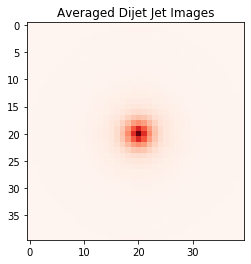

In [3]:
#Load Images
filepath = "/eos/user/m/miochoa/public/JetImages/"
images_train = h5py.File(filepath+"JZ5W_Training_Images.hdf5", "r")["images"]
images_val = h5py.File(filepath+"JZ5W_Validation_Images.hdf5", "r")["images"]
images_anom = h5py.File(filepath+"TTBar_Anomaly_Images.hdf5", "r")["images"]

#Plots of the Jet Images"
images_train_sum = np.sum(images_train, axis=0)
images_train_sum = np.divide(images_train_sum, np.sum(images_train_sum))

images_anom_sum = np.sum(images_anom, axis=0)
images_anom_sum = np.divide(images_anom_sum, np.sum(images_anom_sum))

plt.imshow(images_train_sum, cmap="Reds")
plt.title("Averaged Dijet Jet Images")
plt.savefig("Dijet_Images.png")
plt.show()

plt.imshow(images_anom_sum, cmap="Reds")
plt.title("Averaged Anomaly(TTBar) Jet Images")
plt.savefig("Anomaly_Images.png")
plt.show()

Some text goes here.

In [4]:
# preparing data
#image_size = x_train.shape[1]
image_size = 40
images_train = np.reshape(images_train, [-1, image_size, image_size, 1])
images_val = np.reshape(images_val, [-1, image_size, image_size, 1])
images_anom = np.reshape(images_anom, [-1, image_size, image_size, 1])

labels = np.concatenate((np.zeros(len(images_val)), np.ones(len(images_anom))))
val_data = np.concatenate((images_val, images_anom), axis=0)

In [5]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 500
kernel_size = 3
filters = 16
latent_dim = 4
epochs = 10

# VAE model = encoder + decoder
# build encoder model

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 40, 40, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 20, 20, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 10, 10, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 6400)         0           conv2d_2[0][0]                   
____________________________________________________________________________________________

__We should prepare an already trained model for the tutorial.__

In [6]:
###TRAINING###
data = (val_data, labels, images_train, images_val, images_anom)

reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
delta = 0.1
kl_loss = K.minimum(kl_loss, delta)
vae_loss = K.mean(reconstruction_loss + 0.25*kl_loss)
vae.add_loss(vae_loss)
opt = optimizers.Adam(learning_rate=0.0001)
vae.compile(optimizer=opt)
vae.summary()
models = (encoder, decoder, vae)
#plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

#if args.weights:
#    vae.load_weights(args.weights)
#else:
# train the autoencoder
vae.fit(images_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(images_val, None))
vae.save_weights('vae_cnn.h5')

#plot_results(models, data, batch_size=batch_size, model_name="vae_cnn")

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 40, 40, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 4), (None, 4), (N 121368    
_________________________________________________________________
decoder (Model)              (None, 40, 40, 1)         87681     
Total params: 209,049
Trainable params: 209,049
Non-trainable params: 0
_________________________________________________________________
Train on 99945 samples, validate on 49973 samples
Epoch 1/10
99945/99945 [==============================] - 65s 649us/step - loss: 142.5821 - val_loss: 0.1735
Epoch 2/10
99945/99945 [==============================] - 63s 634us/step - loss: 0.1014 - val_loss: 0.0799
Epoch 3/10
99945/99945 [==============================] - 64s 636us/step - loss: 0.0741 - val_loss: 0.0702
Epoch 4/10
999

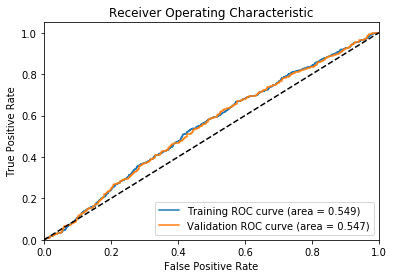

In [7]:
model_name = "vae_cnn"

x_test, y_test, x_train, x_val, x_anom = data
os.makedirs(model_name, exist_ok=True)

filename = os.path.join(model_name, "vae_mean.png")
# display a 2D plot of the digit classes in the latent space
z_mean, _, _ = encoder.predict(x_test,
                               batch_size=batch_size)
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.savefig(filename)
plt.show()
#plt.clf()

filename = os.path.join(model_name, "vae_loss.png")
losses_train=[]
losses_val=[]
losses_anom=[]
for i in range(0, len(x_train), 50):
  losses_train.append(vae.evaluate(x_train[i:i+50], batch_size=50, verbose=0))
for i in range(0, len(x_val), 50):
  losses_val.append(vae.evaluate(x_val[i:i+50], batch_size=50, verbose=0))
for i in range(0, len(x_anom), 50):
  losses_anom.append(vae.evaluate(x_anom[i:i+50], batch_size=50, verbose=0))
bins = np.histogram(np.hstack((losses_val,losses_anom)), bins=50)[1]
plt.hist(losses_val, bins, alpha=0.6, label="Normal")
plt.hist(losses_anom, bins, alpha=0.6, label="Anomalous")
plt.xlabel("VAE Loss")
plt.legend()
plt.savefig(filename)
plt.show()
#plt.clf() 

filename = os.path.join(model_name, "vae_roc.png")
labels_train = np.zeros(len(losses_train))
labels_val = np.zeros(len(losses_val))
labels_anom = np.ones(len(losses_anom))
labels_train = np.concatenate((labels_train, labels_anom))
labels_val = np.concatenate((labels_val, labels_anom))
losses_train = np.concatenate((losses_train, losses_anom))
losses_val = np.concatenate((losses_val, losses_anom))
fpr_train, tpr_train, _ = roc_curve(labels_train, losses_train)
fpr_val, tpr_val, _ = roc_curve(labels_val, losses_val)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_val = auc(fpr_val, tpr_val)
plt.plot(fpr_train, tpr_train, label="Training ROC curve (area = %0.3f)" % (roc_auc_train))
plt.plot(fpr_val, tpr_val, label="Validation ROC curve (area = %0.3f)" % (roc_auc_val))
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.savefig(filename)
plt.show()
#plt.clf() 